# &#x1F4D1; &nbsp; $\mathfrak {P8: \ Analyzing \ the \ NYC \ Subway \ Dataset}$

###  &#x1F4CA; &nbsp; Section 0. References and Code Library

Turnstile and Weather Variables: 
https://s3.amazonaws.com/uploads.hipchat.com/23756/665149/05bgLZqSsMycnkg/turnstile-weather-variables.pdf

Scipy. Statistics in Python:
http://www.scipy-lectures.org/packages/statistics/index.html

Hypothesis Testing - MIT OpenCourseWare:
https://ocw.mit.edu/resources/res-6-009-how-to-process-analyze-and-visualize-data-january-iap-2012/lectures-and-labs/MITRES_6_009IAP12_lab3a.pdf

Assumptions of the Mann-Whitney U test:
https://statistics.laerd.com/premium-sample/mwut/mann-whitney-test-in-spss-2.php

In [1]:
from IPython.core.display import HTML
hide_code = ''
HTML('''
<style>
body {background-color: aliceblue;}
a {color: steelblue;}
h1, h2, h3 { color: #348ABD;}
</style>
<script>code_show = true; 
function code_display() {
    if (code_show) {
        $('div.input').each(function(id) {
            if (id == 0 || $(this).html().indexOf('hide_code') > -1) {$(this).hide();}
        });
        $('div.output_prompt').css('opacity', 0);
    } else {
        $('div.input').each(function(id) {$(this).show();});
        $('div.output_prompt').css('opacity', 1);
    }
    code_show = !code_show;
} 
$(document).ready(code_display);</script>
<form action="javascript: code_display()"><input \
style="color: steelblue; background: ghostwhite; opacity: 0.9; " \
type="submit" value="Click to display or hide code"></form>''')

In [55]:
hide_code
# Import libraries
import numpy as np
import pandas as pd
import time
import warnings
import matplotlib
import matplotlib.pyplot as plt
from IPython.core.display import display 

# Display for notebooks
%matplotlib inline

################################
### ADD EXTRA LIBRARIES HERE ###
################################
from scipy.stats import mannwhitneyu
import seaborn as sns
from sklearn import linear_model
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler

### &#x1F4CA; &nbsp;  Section 1. Statistical Test

#### 1.1 Data Extraction and Description

In [16]:
hide_code
# Load the data from the csv file
turnstile_data = pd.read_csv('turnstile_data_master_with_weather.csv').drop('index', 1)
# Display the data description
turnstile_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Hour,131951.0,10.896158,6.892084,0.00,5.00,12.00,17.00,23.00
ENTRIESn_hourly,131951.0,1095.348478,2337.015421,0.00,39.00,279.00,1109.00,51839.00
EXITSn_hourly,131951.0,886.890838,2008.604886,0.00,32.00,232.00,847.00,45249.00
maxpressurei,131951.0,30.031894,0.125689,29.74,29.96,30.03,30.10,30.31
maxdewpti,131951.0,57.241302,8.770891,39.00,50.00,57.00,64.00,70.00
mindewpti,131951.0,48.259013,11.305312,22.00,38.00,51.00,55.00,66.00
minpressurei,131951.0,29.892714,0.146384,29.54,29.84,29.91,29.97,30.23
meandewpti,131951.0,52.703526,9.943590,31.00,45.00,54.00,60.00,68.00
meanpressurei,131951.0,29.965077,0.130461,29.64,29.91,29.96,30.05,30.27
fog,131951.0,0.167100,0.373066,0.00,0.00,0.00,0.00,1.00


In [17]:
hide_code
print ('Data Medians')
turnstile_data.median()

Data Medians


Hour                12.00
ENTRIESn_hourly    279.00
EXITSn_hourly      232.00
maxpressurei        30.03
maxdewpti           57.00
mindewpti           51.00
minpressurei        29.91
meandewpti          54.00
meanpressurei       29.96
fog                  0.00
rain                 0.00
meanwindspdi         5.00
mintempi            54.00
meantempi           63.00
maxtempi            71.00
precipi              0.00
thunder              0.00
dtype: float64

***Question 1.1*** Which statistical test did you use to analyze the NYC subway data? Did you use a one-tail or a two-tail P value? What is the null hypothesis? What is your p-critical value?

***Answer 1.1*** 

The *Mann-Whitney U Test* to compare the ridership of NYC subway in rainy and non-rainy days is a good choice. 

The column *'ENTRIESn_hourly'* will be the target and the column *'rain'* - the feature. 

We will test the *null hypothesis*: the median / the mean of ridership in NYC subway is the same for rainy and non-rainy days. Another variant of this hypothesis could be: the difference between ridership medians / means for rainy and non-rainy days is equal to zero.

We will use a *two-tailed test* to find the statistical significance in both possible directions of interest.

Let's setup the *p-critical value* is equal to 0.05: we will reject the null hypothesis at the *confidence level* of 95%.

#### 1.2 Data Exploration
Let's plot the distribution of *'ENTRIESn_hourly*. The range of x-axis and y-axis is limited for better visualization.

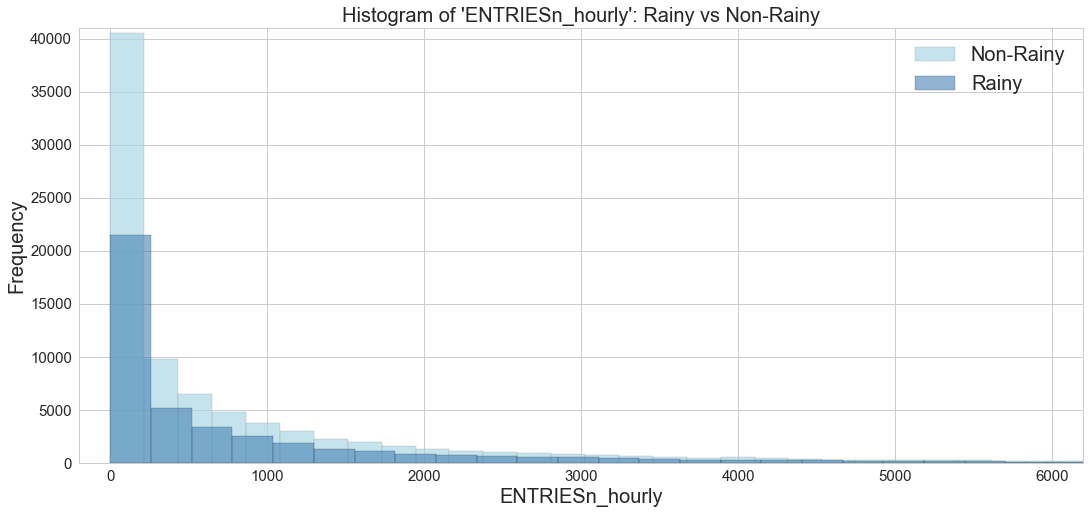

In [37]:
hide_code
rainy_entries_hourly = turnstile_data['ENTRIESn_hourly'][turnstile_data['rain']==1]
non_rainy_entries_hourly = turnstile_data['ENTRIESn_hourly'][turnstile_data['rain']==0]

matplotlib.rcParams['figure.figsize'] = (18, 8)
plt.style.use('seaborn-whitegrid')
plt.figure()

non_rainy_entries_hourly.hist(bins=200, color = 'lightblue', edgecolor='grey',alpha=0.7)
rainy_entries_hourly.hist(bins=200, color='steelblue', edgecolor='black', alpha=0.6)

plt.xlabel("ENTRIESn_hourly", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.tick_params(axis='both', labelsize=15)
plt.axis((-200,6200,0,41000))
plt.title("Histogram of 'ENTRIESn_hourly': Rainy vs Non-Rainy", fontsize=20)
plt.legend(['Non-Rainy','Rainy'], fontsize=20)

As we can see, two distributions have the same shape and the data is not normally distributed, the mean and the median vary significantly (indicating a large skew). If we apply a non-linear scaling we will observe very similar shapes too.

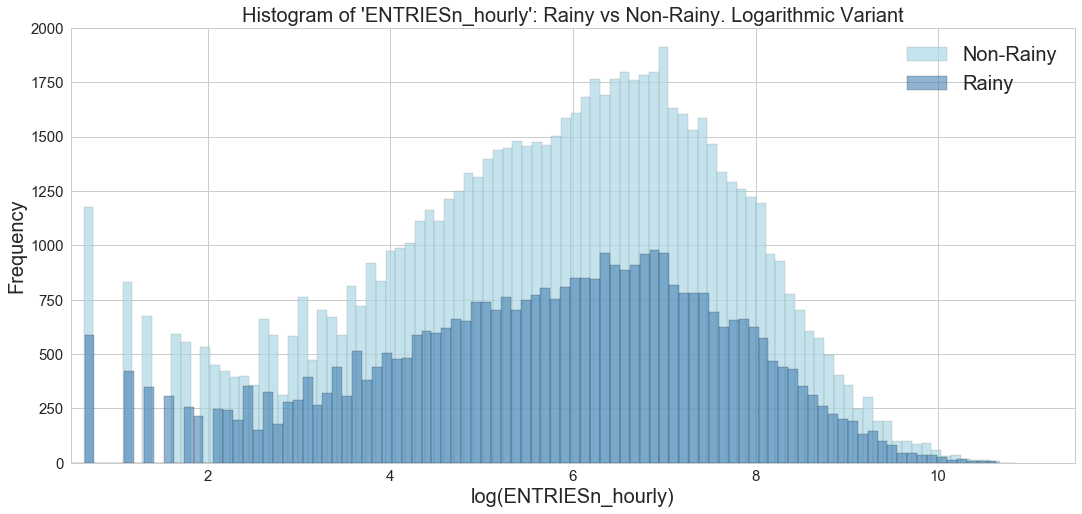

In [36]:
hide_code
matplotlib.rcParams['figure.figsize'] = (18, 8)
plt.style.use('seaborn-bright')
plt.figure()

np.log(non_rainy_entries_hourly+1).hist(bins=100, color = 'lightblue', edgecolor='grey',alpha=0.7)
np.log(rainy_entries_hourly+1).hist(bins=100, color='steelblue', edgecolor='black', alpha=0.6)

plt.axis((0.5,11.5,0,2000))
plt.xlabel("log(ENTRIESn_hourly)", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.tick_params(axis='both', labelsize=15)
plt.title("Histogram of 'ENTRIESn_hourly': Rainy vs Non-Rainy. Logarithmic Variant", fontsize=20)
plt.legend(['Non-Rainy','Rainy'], fontsize=20)

***Question 1.2*** Why is this statistical test applicable to the dataset? In particular, consider the assumptions that the test is making about the distribution of ridership in the two samples.

***Answer 1.2***

The *Mann-Whitney U Test* is a non-parametric alternative test for comparing two sample medians / means (or two distributions) that come from the same population.

We have noted that the distribution of *'ENTRIESn_hourly'* is not normal so we cannot use the t-test in this case.

The features' specifics for the Mann-Whitney U test:

- 1) one dependent variable is measured at the continuous or ordinal level (*'ENTRIESn_hourly'*),
- 2) one independent variable consists of two categorical, independent groups (*'rain'*),
- 3) independence of observations (true for this data),
- 4) if two distributions have the same shape, the test determines differences in the medians / means of two groups, if they have different shapes - differences in the distributions of two groups (medians / means in our case).

#### 1.3 Data Test

In [41]:
hide_code
print("ENTRIESn_hourly in rainy days")
rainy_entries_hourly.describe()

ENTRIESn_hourly in rainy days


count    44104.000000
mean      1105.446377
std       2370.527674
min          0.000000
25%         41.000000
50%        282.000000
75%       1103.250000
max      51839.000000
Name: ENTRIESn_hourly, dtype: float64

In [42]:
hide_code
print("ENTRIESn_hourly in non-rainy days")
non_rainy_entries_hourly.describe()

ENTRIESn_hourly in non-rainy days


count    87847.000000
mean      1090.278780
std       2320.004938
min          0.000000
25%         38.000000
50%        278.000000
75%       1111.000000
max      43199.000000
Name: ENTRIESn_hourly, dtype: float64

In [49]:
hide_code
with_rain_median = np.median(rainy_entries_hourly)
without_rain_median = np.median(non_rainy_entries_hourly)
U, p = mannwhitneyu(rainy_entries_hourly, non_rainy_entries_hourly, alternative='two-sided')

print ("Mean for rainy days: {:.0f}".format(with_rain_mean))
print ("Mean for non-rainy days: {:.0f}".format(without_rain_mean))
print ("Median for rainy days: {:.0f}".format(with_rain_median))
print ("Median for non-rainy days: {:.0f}".format(without_rain_median))
print ("Mann-Whitney U test: U = {:.0f}, p = {:.2f}".format(U,p))

Mean for rainy days: 1105
Mean for non-rainy days: 1090
Median for rainy days: 282
Median for non-rainy days: 278
Mann-Whitney U test: U = 1949994921, p = 0.05


***Question 1.3*** What results did you get from this statistical test? These should include the following numerical values: p-values, as well as the medians / means for each of the two samples under test.

***Answer 1.3***

The mean values of ENTRIESn_hourly in rainy days and in non-rainy days are 1105 and 1090. 

The median values of ENTRIESn_hourly in rainy days and in non-rainy days are 282 and 278.

The p-value of Mann-Whitney U-Test is 0.05.

***Question 1.4*** What is the significance and interpretation of these results?

***Answer 1.4***

The median / mean values of ENTRIESn_hourly in rainy days is only a little bit larger than in non-rainy days. We cannot determine whether the null hypothesis is rejected or not based on the difference between each pair of values.

The Mann-Whitney U-Test detects more informative results on whether the null hypothesis is true or not. The p-value of this test is 0.05 and it's equal to p-critical value. Therefore, we can confirm that the null hypothesis is rejected with 95% of confidence level.

### &#x1F4CA; &nbsp;  Section 2. Linear Regression
In this section, we will use the improved dataset turnstile_weather_v2.csv. Let's load and describe it.

In [90]:
hide_code
# Load the data from the csv file
turnstile_data2 = pd.read_csv('turnstile_weather_v2.csv')
# Display the data example
turnstile_data2.head().T

,0,1,2,3,4
UNIT,R003,R003,R003,R003,R003
DATEn,05-01-11,05-01-11,05-01-11,05-01-11,05-01-11
TIMEn,00:00:00,04:00:00,12:00:00,16:00:00,20:00:00
ENTRIESn,4388333,4388333,4388333,4388333,4388333
EXITSn,2911002,2911002,2911002,2911002,2911002
ENTRIESn_hourly,0,0,0,0,0
EXITSn_hourly,0,0,0,0,0
datetime,2011-05-01 00:00:00,2011-05-01 04:00:00,2011-05-01 12:00:00,2011-05-01 16:00:00,2011-05-01 20:00:00
hour,0,4,12,16,20
day_week,6,6,6,6,6


In [93]:
hide_code
# Setup the features
numerical = ['hour', 'precipi', 'tempi', 'pressurei', 'wspdi', 
             'meanprecipi', 'meanpressurei', 'meantempi', 'meanwspdi']
categorical = ['UNIT', 'conds', 'rain']
dropped = ['DATEn', 'TIMEn', 'ENTRIESn', 'EXITSn', 
          'ENTRIESn_hourly', 'EXITSn_hourly', 'datetime', 'day_week', 
          'weekday', 'station', 'latitude', 'longitude',
          'weather_lat', 'weather_lon', 'fog', 'conds']

pre_features = turnstile_data2.drop(dropped, axis = 1)
features = pd.DataFrame(pre_features)

# One-hot encode the dummy features 
for element in categorical:
    features[element] = pd.get_dummies(pre_features[element])
    
# Transform the numerical features
scaler = MinMaxScaler()
features[numerical] = scaler.fit_transform(turnstile_data2[numerical])

# Setup the target
target = turnstile_data2['ENTRIESn_hourly']

# Display the example
features.head(10).T

,0,1,2,3,4,5,6,7,8,9
UNIT,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
hour,0.000000,0.200000,0.600000,0.800000,1.000000,0.000000,0.200000,0.400000,0.600000,0.800000
precipi,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
pressurei,0.870130,0.909091,0.948052,0.922078,0.948052,0.987013,0.935065,0.974026,0.896104,0.792208
rain,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
tempi,0.230179,0.130435,0.388747,0.281330,0.130435,0.079284,0.079284,0.158568,0.258312,0.309463
wspdi,0.152174,0.152174,0.300000,0.652174,0.452174,0.300000,0.200000,0.452174,0.500000,0.500000
meanprecipi,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
meanpressurei,0.949763,0.949763,0.949763,0.949763,0.949763,0.921801,0.921801,0.921801,0.921801,0.921801
meantempi,0.216447,0.216447,0.216447,0.216447,0.216447,0.156798,0.156798,0.156798,0.156798,0.156798


In [94]:
# Fit OLS models
ols_features = sm.add_constant(features)
model = sm.OLS(target, ols_features)
results = model.fit()
print (results.summary())

                            OLS Regression Results                            
Dep. Variable:        ENTRIESn_hourly   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     403.0
Date:                Wed, 22 Feb 2017   Prob (F-statistic):               0.00
Time:                        00:58:37   Log-Likelihood:            -3.9919e+05
No. Observations:               42649   AIC:                         7.984e+05
Df Residuals:                   42637   BIC:                         7.985e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const          1360.3279     70.839     19.203

In [87]:
# Fit SGDRegressor
clf = linear_model.SGDRegressor()
clf.fit(features, target)

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False)

***Question 2.1*** What approach did you use to compute the coefficients theta and produce prediction for ENTRIESn_hourly in your regression model:

- OLS using Statsmodels or Scikit Learn
- Gradient descent using Scikit Learn
- Or something different?

***Answer 2.1***

To produce predictions I would like to try a simple ordinary least squares model *OLS Statsmodels* and stochastic gradient descent regression *SGDRegressor Scikit Learn*. It will be interesting to compare the results.

***Question 2.2*** What features (input variables) did you use in your model? Did you use any dummy variables as part of your features?

***Answer 2.2***

I have included the wide spectrum of the features in the dataset in the model: 

- quantitative features: precipi, tempi, pressurei, wspdi, meanprecipi, meanpressurei, meantempi, meanwspdi;
- dummy features: hour, fog, conds, rain.

***Question 2.3*** Why did you select these features in your model? We are looking for specific reasons that lead you to believe that
the selected features will contribute to the predictive power of your model.
Your reasons might be based on intuition. For example, response for fog might be: “I decided to use fog because I thought that when it is very foggy outside people might decide to use the subway more often.”
Your reasons might also be based on data exploration and experimentation, for example: “I used feature X because as soon as I included it in my model, it drastically improved my R2 value.”  

***Answer 2.3***

***Question 2.4*** What are the parameters (also known as "coefficients" or "weights") of the non-dummy features in your linear regression model?

***Answer 2.4***

***Question 2.5*** What is your model’s R2 (coefficients of determination) value?

***Answer 2.5***

***Question 2.6*** What does this R2 value mean for the goodness of fit for your regression model? Do you think this linear model to predict ridership is appropriate for this dataset, given this R2  value?

***Answer 2.6***

### &#x1F4CA; &nbsp; Section 3. Visualization

Please include two visualizations that show the relationships between two or more variables in the NYC subway data.
Remember to add appropriate titles and axes labels to your plots. Also, please add a short description below each figure commenting on the key insights depicted in the figure.

***Question 3.1*** One visualization should contain two histograms: one of  ENTRIESn_hourly for rainy days and one of ENTRIESn_hourly for non-rainy days.

You can combine the two histograms in a single plot or you can use two separate plots.
If you decide to use to two separate plots for the two histograms, please ensure that the x-axis limits for both of the plots are identical. It is much easier to compare the two in that case.
For the histograms, you should have intervals representing the volume of ridership (value of ENTRIESn_hourly) on the x-axis and the frequency of occurrence on the y-axis. For example, each interval (along the x-axis), the height of the bar for this interval will represent the number of records (rows in our data) that have ENTRIESn_hourly that falls in this interval.

Remember to increase the number of bins in the histogram (by having larger number of bars). The default bin width is not sufficient to capture the variability in the two samples.

***Answer 3.1***

***Question 3.2*** One visualization can be more freeform. You should feel free to implement something that we discussed in class (e.g., scatter plots, line plots) or attempt to implement something more advanced if you'd like. Some suggestions are:

- Ridership by time-of-day
- Ridership by day-of-week

***Answer 3.2***

### &#x1F4CA; &nbsp;  Section 4. Conclusion

Please address the following questions in detail. Your answers should be 1-2 paragraphs long.

***Question 4.1*** From your analysis and interpretation of the data, do more people ride
the NYC subway when it is raining or when it is not raining?  

***Answer 4.1***

***Question 4.2*** What analyses lead you to this conclusion? You should use results from both your statistical
tests and your linear regression to support your analysis.

***Answer 4.2***

### &#x1F4CA; &nbsp;  Section 5. Reflection

Please address the following questions in detail. Your answers should be 1-2 paragraphs long.

***Question 5.1*** Please discuss potential shortcomings of the methods of your analysis, including:

- Dataset,
- Analysis, such as the linear regression model or statistical test.

***Answer 5.1***

***Question 5.2*** (Optional) Do you have any other insight about the dataset that you would like to share with us?

***Answer 5.2***